In [1]:

import keras
from keras import layers
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
from tensorflow.keras import datasets, layers, models, losses

In [2]:
dataset = tfds.load('bee_dataset', split=['train'], as_supervised=True)

In [3]:
#Split between training data, validation data, test data
splitSize = (0.0, 0.765, 0.9, 1.0)

Testing precision on red channel only

In [4]:
array = np.vstack(tfds.as_numpy(dataset[0]))
ranges = list([int(array.shape[0] * x) for x in splitSize])

def getDataset(ranges, idx):
    return (
        np.array(list(map(lambda x: x[0][:, :, 0], array[ranges[idx]: ranges[idx + 1]]))),
        np.array(list(map(lambda x: x[1]['cooling_output'], array[ranges[idx]: ranges[idx + 1]]))),
        np.array(list(map(lambda x: x[1]['pollen_output'], array[ranges[idx]: ranges[idx + 1]]))),
        np.array(list(map(lambda x: x[1]['varroa_output'], array[ranges[idx]: ranges[idx + 1]]))),
        np.array(list(map(lambda x: x[1]['wasps_output'], array[ranges[idx]: ranges[idx + 1]])))
    )
train_images, train_labels1,train_labels2,train_labels3, train_labels4= getDataset(ranges, 0)
validation_images, validation_labels1,validation_labels2, validation_labels3, validation_labels4 = getDataset(ranges, 1)
test_images, test_labels1,test_labels2,test_labels3, test_labels4  = getDataset(ranges, 2)

<ipython-input-4-e32f162bd591>:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  array = np.vstack(tfds.as_numpy(dataset[0]))
/usr/local/lib/python3.8/dist-packages/numpy/core/shape_base.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


In [5]:
train_labels = np.dstack((train_labels1, train_labels2, train_labels3,train_labels4)).squeeze()
validation_labels = np.dstack((validation_labels1,validation_labels2, validation_labels3, validation_labels4)).squeeze()
test_labels = np.dstack((test_labels1,test_labels2,test_labels3, test_labels4)).squeeze()
train_labels.shape, train_labels[:10]

((5729, 4), array([[0., 0., 0., 1.],
        [0., 0., 1., 0.],
        [0., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]]))

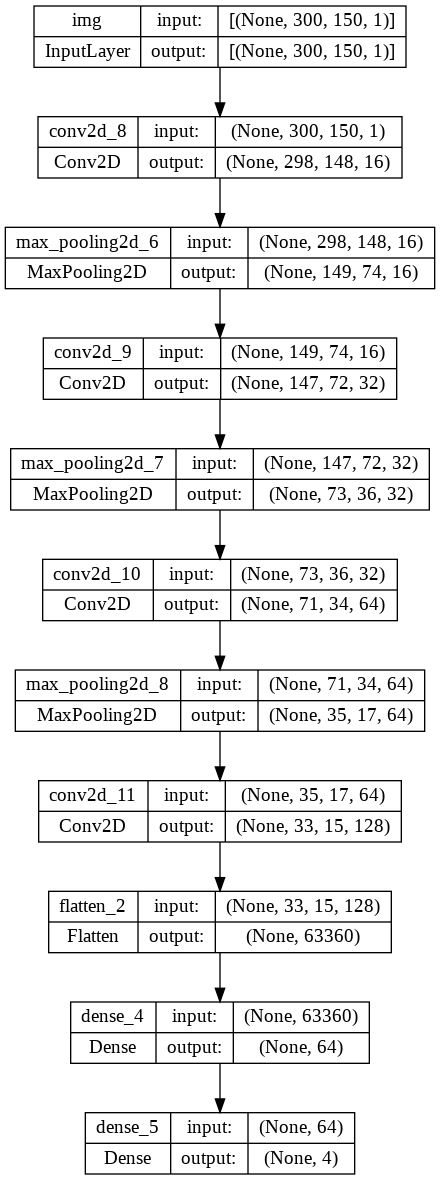

In [16]:
_input = keras.Input(shape=(300, 150, 1), name="img")
x = layers.Conv2D(16, (3, 3), activation='relu')(_input)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='tanh')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='tanh')(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='tanh')(x)
_output = layers.Dense(4)(x)
model_all = keras.Model(_input, _output, name="model_all")

keras.utils.plot_model(model_all, "model.png",show_shapes=True)

In [10]:

model_all.compile(optimizer=tf.keras.optimizers.Adadelta(), loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
history_all = model_all.fit(train_images, train_labels, batch_size=32, epochs=25, validation_data=(validation_images, validation_labels))

print(max(history_all.history['accuracy']))

Epoch 1/25
180/180 [==============================] - 6s 29ms/step - loss: 0.7702 - accuracy: 0.4130 - val_loss: 0.7750 - val_accuracy: 0.5623
Epoch 2/25
180/180 [==============================] - 5s 28ms/step - loss: 0.7363 - accuracy: 0.5497 - val_loss: 0.7424 - val_accuracy: 0.5366
Epoch 3/25
180/180 [==============================] - 5s 28ms/step - loss: 0.6913 - accuracy: 0.5549 - val_loss: 0.6945 - val_accuracy: 0.5464
Epoch 4/25
180/180 [==============================] - 5s 29ms/step - loss: 0.6355 - accuracy: 0.5498 - val_loss: 0.6275 - val_accuracy: 0.5860
Epoch 5/25
180/180 [==============================] - 5s 28ms/step - loss: 0.5861 - accuracy: 0.5603 - val_loss: 0.5840 - val_accuracy: 0.4713
Epoch 6/25
180/180 [==============================] - 5s 28ms/step - loss: 0.5495 - accuracy: 0.5467 - val_loss: 0.5614 - val_accuracy: 0.5919
Epoch 7/25
180/180 [==============================] - 5s 28ms/step - loss: 0.5211 - accuracy: 0.5558 - val_loss: 0.5367 - val_accuracy: 0.6047

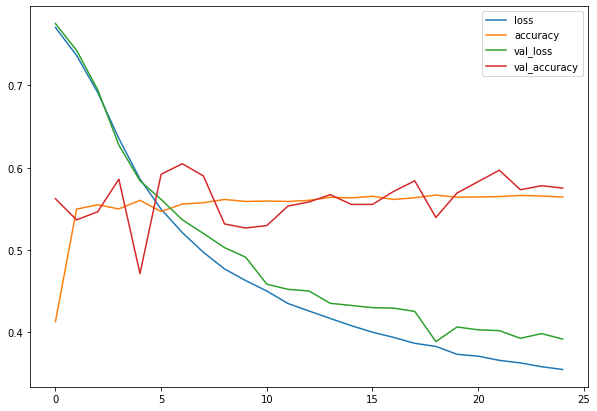

In [13]:
import pandas as pd
pd.DataFrame(history_all.history).plot(figsize=(10, 7));

In [15]:
model_all.evaluate(test_images, test_labels)

24/24 [==============================] - 0s 14ms/step - loss: 0.3868 - accuracy: 0.5848


[0.38676515221595764, 0.584779679775238]